In [86]:
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp
from PIL import Image
from matplotlib import pyplot as plt
from scipy.linalg import norm


In [87]:
class VQSVD():
    def __init__(self, matrix: pnp.ndarray, 
                 weights: pnp.ndarray, 
                 num_qubits: int, depth: int, rank: int, 
                 lr: float, itr: int, seed: int):

        # Hyperparameters
        self.rank = rank
        self.lr = lr
        self.itr = itr
        self.num_qubits = num_qubits
        self.depth = depth

        pnp.random.seed(seed)

        # Parameter shapes for U and V
        self.param_shape = (depth, 2,num_qubits)
        self.theta = pnp.random.uniform(0, 2*pnp.pi, self.param_shape, requires_grad=True)
        self.phi = pnp.random.uniform(0, 2*pnp.pi, self.param_shape, requires_grad=True)

        # Ansatz function (should be defined outside the class)
        self.ansatz = self._ansatz
        self.M = pnp.array(matrix)
        self.weight = pnp.array(weights)
        self.U = self.get_unitary_matrix(self.ansatz, self.theta, self.num_qubits)
        self.V = self.get_unitary_matrix(self.ansatz, self.phi, self.num_qubits)


    def _ansatz(self, params, wires):
        depth = params.shape[0]
        num_qubits = len(wires)
        for d in range(depth):
            for q in range(num_qubits):
                qml.RY(params[d, 0, q], wires=wires[q])
                qml.RZ(params[d, 1, q], wires=wires[q])
            for q in range(num_qubits - 1):
                qml.CNOT(wires=[wires[q], wires[q+1]])


    def get_unitary_matrix(self, ansatz_fn, params, num_qubits):
        dev = qml.device("default.qubit", wires=num_qubits)
        basis_states = [format(i, f"0{num_qubits}b") for i in range(2**num_qubits)]
        matrix_columns = []
        @qml.qnode(dev)
        def basis_circuit(state_bin, params):
            # Prepare basis state
            for j, bit in enumerate(reversed(state_bin)):
                if bit == "1":
                    qml.PauliX(wires=j)
            ansatz_fn(params, wires=range(num_qubits))
            return qml.state()

        for b in basis_states:
            final_state = basis_circuit(b, params)
            matrix_columns.append(final_state)
        return pnp.column_stack(matrix_columns)

    def get_matrix_U(self):
        return self.U

    def get_matrix_V(self):
        return self.V   

    def loss_func(self, theta, phi):
        self.U =  self.get_unitary_matrix(self.ansatz, theta, self.num_qubits)
        self.V =  self.get_unitary_matrix(self.ansatz, phi, self.num_qubits)
        loss = pnp.array(0.0)
        singular_values = []
        for i in range(self.rank):
            value = pnp.real(pnp.conj(self.U.T) @ self.M @ self.V)[i, i]
            loss -= pnp.real(self.weight)[i] * value
            singular_values.append(value)
        return loss, singular_values

    # Train the VQSVD network
    def train(self):
        loss_list, singular_value_list = [], []
        optimizer = qml.AdamOptimizer(self.lr)
        theta = self.theta
        phi = self.phi
        for itr in range(self.itr):
            (theta, phi), loss = optimizer.step_and_cost(
                lambda t, p: self.loss_func(t, p)[0], theta, phi
            )
            loss_val, singular_values = self.loss_func(theta, phi)
            loss_list.append(loss_val)
            singular_value_list.append(singular_values)
            if itr % 10 == 0:
                print(f'iter: {itr}, loss: {loss_val:.4f}')
        # Save final parameters
        self.theta = theta
        self.phi = phi
        return loss_list, singular_value_list
    

    def frobenius_norm_error(self, M, M_err, U_learned, singular_value_list, V_dagger_learned, RANK):        
        err_local, err_subfull, err_SVD = [], [], []
        U, D, V_dagger = np.linalg.svd(M, full_matrices=True)
        singular_value_pnp = pnp.array(singular_value_list[-1])
        singular_value = singular_value_pnp.numpy()

        for i in range(RANK):
            lowrank_mat = U[:, :i] @ np.diag(D[:i]) @ V_dagger[:i, :]
            recons_mat = U_learned[:, :i] @ np.diag(singular_value[:i]) @ V_dagger_learned[:i, :]
            err_local.append(norm(lowrank_mat - recons_mat))
            err_subfull.append(norm(M_err - recons_mat))
            err_SVD.append(norm(M_err - lowrank_mat))
        return err_local, err_subfull, err_SVD

In [88]:
class LossPlot:
    def __init__(self):
        self.route = '../results/'

    def loss_plot(self, loss):
        '''
        Loss is a list, this function plots loss over iteration
        '''
        plt.plot(list(range(1, len(loss)+1)), loss)
        plt.xlabel('iteration')
        plt.ylabel('loss')
        plt.title('VQSVD Loss Learning Curve')
        plt.grid(True)        
        self.save_plot('figure_01.png')
        plt.show()
        plt.close()
        
    
    def plot_singular_values_comparison(self, params:dict):
        RANK = params.get('rank')
        err_subfull = params.get('err_subfull')
        err_SVD = params.get('err_SVD')        
        fig, ax = plt.subplots()
        ax.plot(list(range(1, RANK+1)), err_subfull, "o-.", 
                label = 'Reconstruction via VQSVD')
        ax.plot(list(range(1, RANK+1)), err_SVD, "^--", 
                label='Reconstruction via SVD')
        plt.xlabel('Singular Value Used (Rank)', fontsize = 14)
        plt.ylabel('Norm Distance', fontsize = 14)
        leg = plt.legend(frameon=True)
        leg.get_frame().set_edgecolor('k')
        self.save_plot('figure_02.png')
        plt.show()
        plt.close()
     
    def plot_matrix_as_image(self, M, title="Reconstruction"):
        plt.imshow(M, cmap="gray")
        plt.title(title)
        plt.colorbar()
        self.save_plot('figure_03.png')
        plt.show()
        plt.close()

    def save_plot(self, filename):
        plt.savefig(self.route + filename)
        print(f"Plot saved as {self.route + filename}")

In [89]:
class MatGenerator:
    def __init__(self, num_qubits):
        self.num_qubits = num_qubits

    def from_image(self, image_path):
        """
        Genera una matriz a partir de una imagen en escala de grises.
        """
        img = Image.open(image_path)
        imgmat = np.array(list(img.getdata(band=0)), float)
        imgmat.shape = (img.size[1], img.size[0])
        imgmat = np.matrix(imgmat) / 255
        return imgmat.astype('complex128')

    def random_matrix(self):
        """
        Genera una matriz cuadrada aleatoria compleja de tamaño 2**num_qubits.
        """
        size = 2 ** self.num_qubits
        real_part = np.random.randint(10, size=(size, size))
        imag_part = np.random.randint(10, size=(size, size))
        M = real_part + 1j * imag_part
        return M.astype('complex128')

In [90]:
# Set circuit parameters
cir_depth = 40      # depth of circuit
num_qubits = 5      # Number of qubits

# Hyper-parameters
RANK = 8           # Set the number of rank you want to learn
ITR = 200           # Number of iterations
LR = 0.02           # Learning rate
SEED = 14           # Random number seed

# Set the learning weight
weight = np.arange(2 * RANK, 0, -2).astype('complex128')

# Record the optimization process
loss_list, singular_value_list = [], []
U_learned, V_dagger_learned = [], []
matrix_gen = MatGenerator(num_qubits)
mat = matrix_gen.from_image('../figures/MNIST_32.png')
#mat = matrix_gen.random_matrix()
#M_err = np.copy(mat)
net = VQSVD(matrix=mat, weights=weight, num_qubits=num_qubits, depth=cir_depth, rank=RANK, lr=LR, itr=ITR, seed=SEED)
loss_list, singular_value_list = net.train()



iter: 0, loss: -122.0626
iter: 10, loss: -457.6958
iter: 20, loss: -513.8127
iter: 30, loss: -547.3028
iter: 40, loss: -568.1902
iter: 50, loss: -579.4262
iter: 60, loss: -587.1793
iter: 70, loss: -593.2848
iter: 80, loss: -597.7960
iter: 90, loss: -601.1734
iter: 100, loss: -603.7356
iter: 110, loss: -605.7647
iter: 120, loss: -607.4760
iter: 130, loss: -608.6215
iter: 140, loss: -609.2157
iter: 150, loss: -610.6770
iter: 160, loss: -611.6990
iter: 170, loss: -612.4119
iter: 180, loss: -613.0278
iter: 190, loss: -613.6108


Plot saved as ../results/figure_01.png


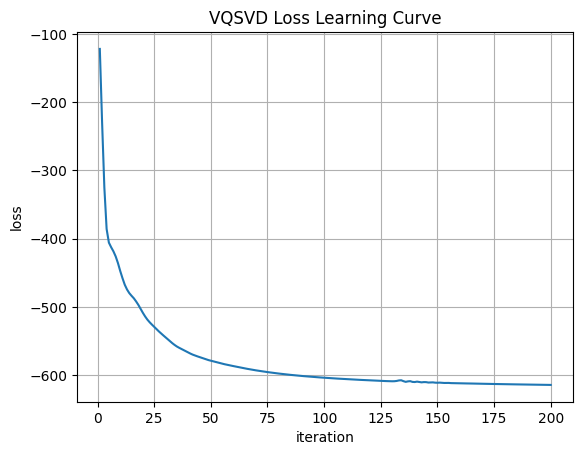

Plot saved as ../results/figure_02.png


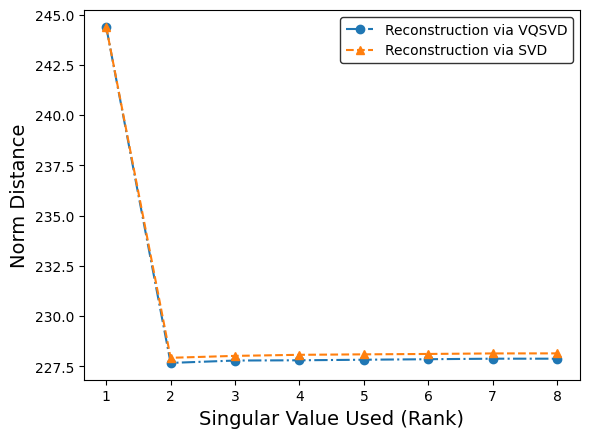

Plot saved as ../results/figure_03.png


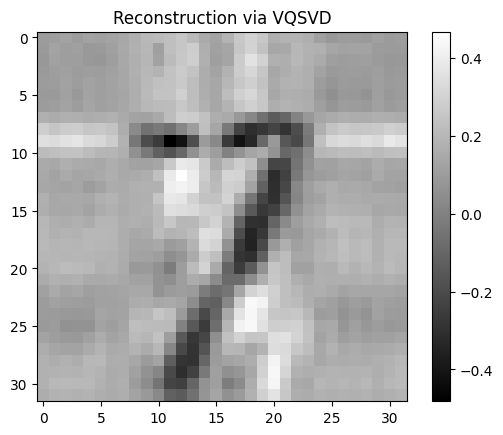

In [91]:
# Record the last two unitary matrices learned
U_learned = net.get_matrix_U().numpy()
V_dagger_learned = net.get_matrix_V().numpy().conj().T
plot = LossPlot()
plot.loss_plot(loss_list)

#def random_M_generator(num_qubits):
#    return np.random.randint(10, size = (2**num_qubits, 2**num_qubits)) + 1j*np.random.randint(10, size = (2**num_qubits, 2**num_qubits))

M = matrix_gen.random_matrix()
M_err = np.copy(M)
err_local, err_subfull, err_SVD = net.frobenius_norm_error(net.M, M_err, U_learned, singular_value_list, V_dagger_learned, RANK)
plot.plot_singular_values_comparison(params={'rank': RANK, 'err_subfull': err_subfull, 'err_SVD': err_SVD})

singular_value_pnp = pnp.array(singular_value_list[-1]) # This is still a pnp.ndarray
singular_value = singular_value_pnp.numpy()
mat = np.matrix(U_learned.real[:, :RANK]) * np.diag(singular_value[:RANK])* np.matrix(V_dagger_learned.real[:RANK, :])
plot.plot_matrix_as_image(mat, title="Reconstruction via VQSVD")
